In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

# Functions

### Functions not setup and seperated in prepare.py file due to the time restraint goal of having deliverables in after 36 hours

In [2]:
def clean(df):
    '''
    This Function filters out the df by the city of Los Angeles, drops columns,
    renames, sets the index to the date, & converts to Fahrenheit
    
    '''
    
    # Filtering out by USA
    df = df[df.Country == "United States"]
    
    # Filtering out by Los Angeles
    df = df[df.City == "Los Angeles"]
    
    # Dropping columns that wont be needed
    df = df.drop(columns=['Country', 'Latitude', 'Longitude', 'City', 'AverageTemperatureUncertainty'])
    
    # Renaming AverageTemperature to just temp
    df = df.rename(columns={"AverageTemperature": "temp"})
    
    # Converting sale_date type object to datetime64
    df.dt = pd.to_datetime(df.dt)
    
    # Removing dates before 2010-09-01, leaving me excatly 3 years
    df = df[~(df['dt'] < '2006-09-01')]
    
    # Resetting the index to datetime
    df = df.set_index('dt').sort_index()
    
    # Convert to fahrenheit
    df.temp = df.temp.apply(celsius_to_fahrenheit)
    
    return df

In [3]:
def celsius_to_fahrenheit(c):
    '''
    Converting Celsius_to_fahrenheit
    '''
    c = float(c)
    c = (c*(9/5)) + 32
    return c

In [4]:
def split(df):
    '''
    Splits the data into train, validate, and split. Then resampling by Month
    '''
    # Train 09/2009 - 12/2011
    train = df['2009-09-01':'2011-12-01']
    
    # Validate 12/2011 - 12/2012
    validate = df['2012-01-01':'2012-12-01']
    
    # Test 12/2012 - 09/2013
    test = df['2013-01-01':'2013-09-01']
    
        
    # Resampling it so it has a Frequency = "M"
    train = train.resample('M').mean()
    validate = validate.resample('M').mean()
    test = test.resample('M').mean()
    
    return train, validate, test

In [5]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(f'--RMSE: {target_var}')
    plt.show()

In [6]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is goign to take in the model type as a string, the target variable as a string,
    and run the evalute() function to compute the rsme,
    and append to the data frame a row with the model_type, target_var and rmse.
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

In [7]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    Creating a function to grab rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 3)
    return rmse

In [8]:
def plot_samples(target_var):
    '''
    this function wil plot the train, validate and test values for a single varibable across all dates
    '''
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)

In [9]:
def previous_cycle(train, validate, diff, eval_df):
    '''
    This function takes the mean the temp diff and adds that to the train values.
    RMSE is the evaluated and stored in eval_df
    Returns eval_df
    '''
    # Taking the mean of temp
    year_diff = train.temp.diff(diff).mean()
    
    # Creating predictions
    yhat_df[target_var] = train.copy().set_index(validate.index)+year_diff
    
    # Creating a string to label what kind of parameters were entered
    fstring = f'Diff:{diff} Cycle:{len(train)}'
    
    # Save RMSE results to eval_df
    eval_df = append_eval_df(model_type = fstring, target_var = target_var)
    
    return eval_df

In [10]:
def holts(train, level, slope, target_var, eval_df):
    '''
    This function takes in train, level, slope, target_var, and eval_df.
    It creates, fits and uses a holts model
    It then saves the evaluated rmse to eval_df
    returns eval_df
    '''
    
    # Making the model
    model = Holt(train[target_var], exponential = False)
    
    # Fitting the model
    model = model.fit(smoothing_level = level, smoothing_slope = slope, optimized = False)
    
    # Making predictions 
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])
    
    yhat_df[target_var] = round(yhat, 0)
    fstring = f'Holts:L={level}/S={slope}'
    eval_df = append_eval_df(model_type = fstring, target_var = target_var)
    #plot_and_eval(target_var = target_var)
    return eval_df

# Project and Goals

### - The goal of this project is to predict the temperature for the date 2013-09-01 for the city of Los Angeles using time series analysis and have the results delivered within a 36 hour time period.

## Original Hypothesis

### - Using a "previous cycle" model will use the seasons in weather to create an accurate prediction.

# The Plan

### ***Setup***
- Create a final.ipynb
- Create a README.md
- Update .gitignore

### ***Acquire***
- Download data from https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
- Read in CSV to DF
- Run .head(), .info(), .describe()

### ***Prepare***
- Clean data
    - Filter DataFrame out by USA
    - Filter DataFRame out by Los Angeles
    - Drop columns that wont be needed
    - Rename Columns for easier typing and readability
    - Convert date datatype to datetime64
    - Remove dates before 2006-09-01
    - Reset the index to datetime
    - Convert celsius temp values to fahrenheit
- Split Data
    - Split by Date
    - Resample it so it has a Frequency = "M"

### ***Explore***
- Ask and answer as many questions as time will allow
- Create some graphs to visiualize the data

### ***Model***
- Setup baseline my using a simple average technique
- Run a Last Observed Value model
- Run a Moving Average model
- Run a Holt's Linear Trend model
- Run a Previous Cycle model
- Find and evaluate best Validate model to run on Test
- Run Test
- Evaluate Test

### ***Deliver***
- final.ipynb

# Executive Summary - Conclusions & Next Steps

# Conclusion

### - I was able to meet my goal of predicting the temperature of Los Angeles on 2013-09-01 with an accuracy of 99% using time series analysis.
### - My "previous cycle" model did beat my baseline RMSE by roughly 8 Degrees.
### - If I had more time I would have liked to have tested my model on more current dates to predict temperatures.

# Takeaway

### - My model takes the average of the last two years and then it adds that average to the temperature of the day 12 months prior.

# Acquire

In [11]:
# Importing saas.csv to a Data Frame
df = pd.read_csv('temp_city.csv')

In [12]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,8235082.0,16.727433,10.353442,-42.704,10.299,18.831,25.210,39.651
AverageTemperatureUncertainty,8235082.0,1.028575,1.129733,0.034,0.337,0.591,1.349,15.396


### Acquire Take Aways
- Brought in roughly 8.5 million observations and 7 features

# Prepare

### Clean

In [15]:
df = clean(df)

### Split

In [16]:
train, validate, test = split(df)

### Plot the Split

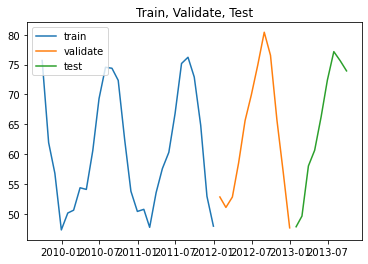

In [17]:
plt.plot(train.index, train.temp, label='train')
plt.plot(validate.index, validate.temp, label='validate')
plt.plot(test.index, test.temp, label='test')
plt.xticks(rotation=0)
plt.title(label='Train, Validate, Test')
plt.legend()
plt.show()

### Shape

In [18]:
train.shape

(28, 1)

In [19]:
validate.shape

(12, 1)

In [20]:
test.shape

(9, 1)

### Prepare Takeaways
- Data Frame was Filtered out by only the City of Los Angeles
- Renamed AverageTemperature to temp
- Dropped all columns except for temp
- Resampled by Month
- Indexed by date
- Indexed sorted by Date

# Explore

### Plotting Defaults

In [21]:
plt.rc('figure', figsize=(9, 4))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

### Graphing

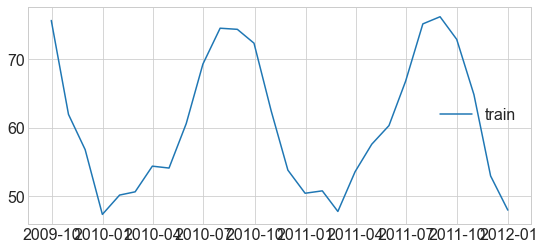

In [22]:
# Taking a look at my train
plt.plot(train.index, train.temp, label='train')
plt.legend()
plt.show()

## Questions

    What is the Average temp?

In [23]:
train.temp.mean()

60.564842857142864

#### `60.56 Degrees Fahrenheit`

    What is Coldest Month?

In [24]:
train.loc[train.temp.idxmin()]

temp    47.3342
Name: 2009-12-31 00:00:00, dtype: float64

#### `December @ 47.33 Degrees`

    What is the Hottest Month?

In [25]:
train.loc[train.temp.idxmax()]

temp    76.2206
Name: 2011-08-31 00:00:00, dtype: float64

#### `August @ 76.22 Degrees`

# Resetting Train index & Saving to Explore for Exploration

In [26]:
# Resettign index
explore = train.reset_index()

In [27]:
# Converting to datetime
explore.dt = pd.to_datetime(explore.dt)

In [28]:
# Creating a month column
explore["month"]= explore.dt.dt.month

In [29]:
# Creating a year column
explore["year"]= explore.dt.dt.year

In [30]:
# Checking average temp by year
explore.groupby('year').temp.mean()

year
2009    60.4400
2010    60.5966
2011    60.5747
Name: temp, dtype: float64

In [31]:
# Checking coldest temp by year
explore.groupby('year').temp.min()

year
2009    47.3342
2010    50.1620
2011    47.7662
Name: temp, dtype: float64

In [32]:
# Checking hottest temp by year
explore.groupby('year').temp.max()

year
2009    75.6770
2010    74.5448
2011    76.2206
Name: temp, dtype: float64

## Hottest Months by Year

In [33]:
# Using idxmax to return loc of the hottest month in 2009
explore.loc[explore[explore.year == 2009].temp.idxmax()]

dt       2009-09-30 00:00:00
temp                  75.677
month                      9
year                    2009
Name: 0, dtype: object

In [34]:
# Using idxmax to return loc of the hottest month in 2010
explore.loc[explore[explore.year == 2010].temp.idxmax()]

dt       2010-07-31 00:00:00
temp                 74.5448
month                      7
year                    2010
Name: 10, dtype: object

In [35]:
# Using idxmax to return loc of the hottest month in 2011
explore.loc[explore[explore.year == 2011].temp.idxmax()]

dt       2011-08-31 00:00:00
temp                 76.2206
month                      8
year                    2011
Name: 23, dtype: object

## Coldest Months by Year

In [36]:
# Using idxmax to return loc of the hottest month in 2009
explore.loc[explore[explore.year == 2009].temp.idxmin()]

dt       2009-12-31 00:00:00
temp                 47.3342
month                     12
year                    2009
Name: 3, dtype: object

In [37]:
# Using idxmax to return loc of the hottest month in 2010
explore.loc[explore[explore.year == 2010].temp.idxmin()]

dt       2010-01-31 00:00:00
temp                  50.162
month                      1
year                    2010
Name: 4, dtype: object

In [38]:
# Using idxmax to return loc of the hottest month in 2011
explore.loc[explore[explore.year == 2011].temp.idxmin()]

dt       2011-02-28 00:00:00
temp                 47.7662
month                      2
year                    2011
Name: 17, dtype: object

### Explore Takeaways

- Coldest Months Range from Dec-Feb year by year
- Hottes Months Range from July-Sep by year to to year
- Coldest Month year 2009-2011 was December
- Hottest Month year 2009-2011 was August
- Graph seems to have a regular looking cycle

# Modeling

### Setting up Target 

In [39]:
# Setting up as global var
target_var='temp'

### Setting up Evaluation DataFrame

In [40]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

# Baseline 

Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

In [41]:
# Taking the mean of temp in train and saving to train_mean
train_mean = round(train[target_var].mean(), 2)
train_mean

60.56

### Making Predictions

In [42]:
# Using train_mean
yhat_df = pd.DataFrame({target_var: [train_mean]}, index = validate.index)

In [43]:
# Checking my prediction values
yhat_df.head(3)

,temp
dt,
2012-01-31,60.56
2012-02-29,60.56
2012-03-31,60.56


### Baseline RMSE

In [44]:
rmse = evaluate(target_var)
print(f'Baseline RSME: {rmse}')

Baseline RSME: 10.748


### Adding Baseline to the Eval Dataframe

In [45]:
# Adding RMSE of baseline Model to my eval datafram
eval_df = append_eval_df(model_type = 'Baseline/Simple AVG', target_var = target_var)
eval_df

,model_type,target_var,rmse
0,Baseline/Simple AVG,temp,10.748


### Plotting Baseline

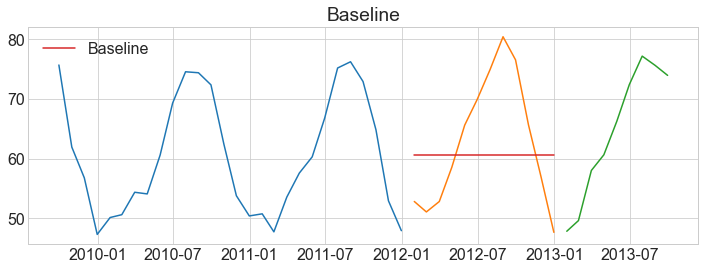

In [46]:
plot_samples(target_var)
plt.plot(yhat_df[target_var], label='Baseline')
plt.title('Baseline')
rmse = evaluate(target_var)
plt.legend()
plt.show()

# Last Observed Value

In [47]:
# Taking the last observed value and saving to 'last_ov'
last_ov = int(train['temp'][-1:][0])
last_ov

47

### Making Predictions

In [48]:
# Making predictions
yhat_df = pd.DataFrame({target_var: [last_ov]}, index = validate.index)
yhat_df.head(3)

,temp
dt,
2012-01-31,47
2012-02-29,47
2012-03-31,47


### Last Observed Value RMSE

In [49]:
rmse = evaluate(target_var)
print(f'Last Observed Value RSME: {rmse}')

Last Observed Value RSME: 18.95


### Adding Last Observed Value to the Eval Dataframe

In [50]:
# Adding RMSE of baseline Model to my eval datafram
eval_df = append_eval_df(model_type = 'Last Observed Value', target_var = target_var)
eval_df

,model_type,target_var,rmse
0,Baseline/Simple AVG,temp,10.748
1,Last Observed Value,temp,18.950


### Plotting Last Observed Value

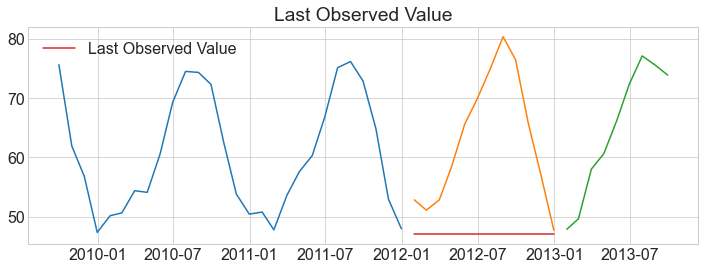

In [51]:
plot_samples(target_var)
plt.plot(yhat_df[target_var], label='Last Observed Value')
plt.title('Last Observed Value')
rmse = evaluate(target_var)
plt.legend()
plt.show()

# Rolling Average

### Setting up period

In [52]:
# 2 month period
period = 2

### Setting up the Rolling AVG

In [53]:
# Taking the rolling method, take the mean of the last 2 months
rolling_avg = round(train[target_var].rolling(period).mean().iloc[-1])
rolling_avg

50

### Making Predictions

In [54]:
# Making predictions
yhat_df = pd.DataFrame({target_var: [rolling_avg]}, index = validate.index)
yhat_df.head(3)

,temp
dt,
2012-01-31,50
2012-02-29,50
2012-03-31,50


### 2 Month Rolling AVG RMSE

In [55]:
rmse = evaluate(target_var)
print(f'2 Month Rolling AVG RSME: {rmse}')

2 Month Rolling AVG RSME: 16.539


### Adding Last Observed Value to the Eval Dataframe

In [56]:
# Adding RMSE of baseline Model to my eval datafram
eval_df = append_eval_df(model_type = '2 Month Rolling AVG', target_var = target_var)
eval_df

,model_type,target_var,rmse
0,Baseline/Simple AVG,temp,10.748
1,Last Observed Value,temp,18.950
2,2 Month Rolling AVG,temp,16.539


### Plotting 2 Month Rolling AVG

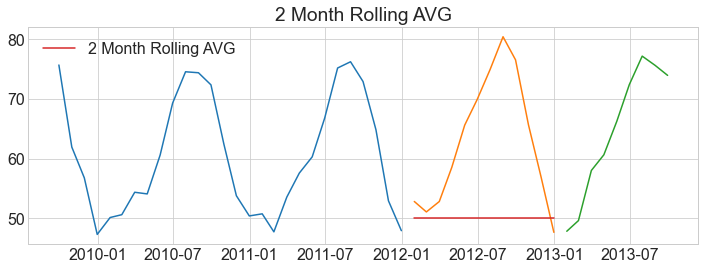

In [57]:
plot_samples(target_var)
plt.plot(yhat_df[target_var], label='2 Month Rolling AVG')
plt.title('2 Month Rolling AVG')
rmse = evaluate(target_var)
plt.legend()
plt.show()

# Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 

### Seasonal Decomposition

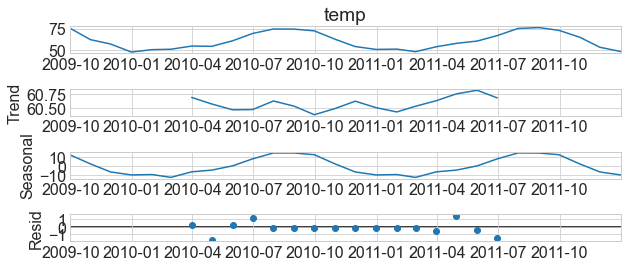

In [58]:
# Plotting trend, seasonality, and residuals
_ = sm.tsa.seasonal_decompose(train[target_var]).plot()
plt.show()

In [59]:
# Creating a loop within a loop to iterate through i and k for level and slope
for i in range(0, 11):
    for k in range(0, 11):
        eval_df = holts(train, (i/10), (k/10), target_var, eval_df)

In [60]:
# Checking RMSE Values
eval_df.tail(3)

,model_type,target_var,rmse
121,Holts:L=1.0/S=0.8,temp,60.820
122,Holts:L=1.0/S=0.9,temp,56.994
123,Holts:L=1.0/S=1.0,temp,52.310


# Predict Based on Previous Cycle

### Re-Split Data by 12 Months

In [61]:
# First 12 months for Train,
train = df['2010-10-01':'2011-09-01']

# Middle 12 months For Validate
validate = df['2011-10-01':'2012-09-01']

# Last 12 months for Test.
test = df['2012-10-01':'2013-09-01']

In [62]:
train.shape

(12, 1)

In [63]:
validate.shape

(12, 1)

In [64]:
test.shape

(12, 1)

In [65]:
# 11 Month Difference
year_diff = train.temp.diff(11).mean()
year_diff

10.472400000000007

In [66]:
# take the values for each day in 2015 and add the average year over year(yoy)(y/y)
yhat_df = train + year_diff

In [67]:
# Resetting index to validate 
yhat_df = yhat_df.set_index(validate.index)

--RMSE: temp


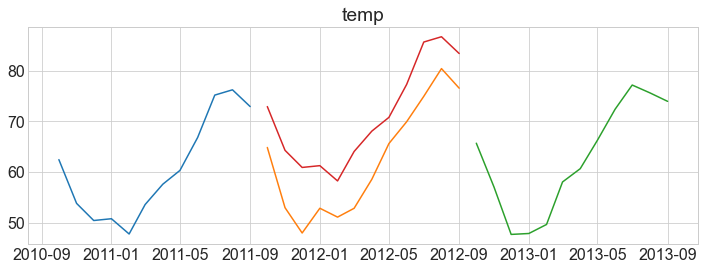

In [68]:
# Saving RMSE results to eval_df and then plotting
eval_df = append_eval_df(model_type = '11month_diff', target_var = target_var)
plot_and_eval(target_var = target_var)

In [69]:
# iterating through range 1, 10 for i, as i represents the diff in months
for i in range(1,11):
    eval_df = previous_cycle(train, validate, i, eval_df)

In [70]:
eval_df

,model_type,target_var,rmse
0,Baseline/Simple AVG,temp,10.748
1,Last Observed Value,temp,18.950
2,2 Month Rolling AVG,temp,16.539
3,Holts:L=0.0/S=0.0,temp,463.513
4,Holts:L=0.0/S=0.1,temp,463.513
...,...,...,...
130,Diff:6 Cycle:12,temp,13.508
131,Diff:7 Cycle:12,temp,15.685
132,Diff:8 Cycle:12,temp,16.847
133,Diff:9 Cycle:12,temp,17.635


### Re-Split Data by 24 Months

In [71]:
# First 24 months for Train,
train = df['2007-10-01':'2009-09-01']

# Middle 24 months For Validate
validate = df['2009-10-01':'2011-09-01']

# Last 24 months for Test.
test = df['2011-10-01':'2013-09-01']

In [72]:
# 23 Month Difference
year_diff = train.temp.diff(23).mean()
year_diff

12.545999999999992

In [73]:
# Making Predictions
yhat_df = train + year_diff

In [74]:
# Resettign index to validate 
yhat_df = yhat_df.set_index(validate.index)

--RMSE: temp


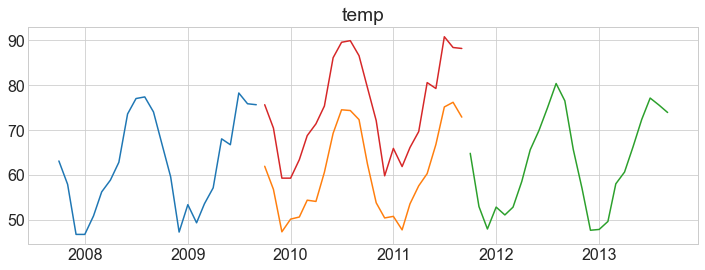

In [75]:
# Saving RMSE to eval_df and plotting
eval_df = append_eval_df(model_type = '23month_diff', target_var = target_var)
plot_and_eval(target_var = target_var)

In [76]:
# iterating through range 1, 23 for i, as i represents the diff in months
for i in range(1,23):
    eval_df = previous_cycle(train, validate, i, eval_df)

### Evaluate

In [77]:
# Looking at the top 5 models (Low RMSE)
eval_df.sort_values(by=['rmse']).head(5)

,model_type,target_var,rmse
125,Diff:1 Cycle:12,temp,2.405
126,Diff:2 Cycle:12,temp,2.763
147,Diff:12 Cycle:24,temp,3.450
136,Diff:1 Cycle:24,temp,3.460
146,Diff:11 Cycle:24,temp,3.812


In [78]:
# Checking to see how many models I created 
len(eval_df)

158

### Modeling Takeaway

- Created 158 Models
- best top 5 Models were of type predict based on previous cycle
- Best Validate RMSE was 2.4 but that was only on a 1 month difference with a 12 month average which didn't seem to flexible
- Best Validate Model seems to be the the one with the larger cycle and a one year difference.  Seems more flexible.
- Moving Forward a cycle of 24 moths and a difference of 12 months model on Test

# Test

### Predict Based on Previous Cycle

### 24 Month Cycle

In [79]:
# First 24 months for Train,
train = df['2007-10-01':'2009-09-01']

# Middle 24 months For Validate
validate = df['2009-10-01':'2011-09-01']

# Last 24 months for Test.
test = df['2011-10-01':'2013-09-01']

### 12 Month Diff Mean

In [80]:
# Making Predictions
yhat_df = validate + train.temp.diff(12).mean()

In [81]:
# Resetting the index to Test
yhat_df.index = test.index

In [82]:
# Calculating the RMSE for Test
rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 3)

In [83]:
# Test RMSE
rmse

3.108

### Plotting Test Predictions Vs. Acutal

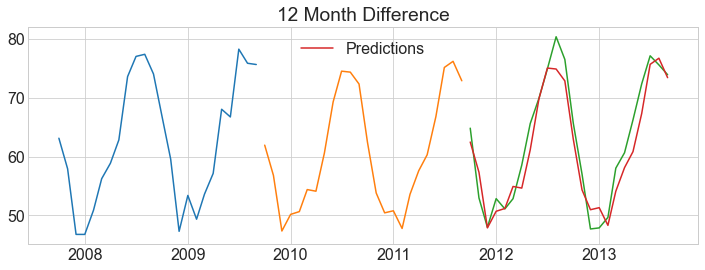

In [84]:
plot_samples(target_var)
plt.plot(yhat_df[target_var], label='Predictions')
plt.title('12 Month Difference')
plt.legend()
plt.show()

# How close was my Temp Prediction on 2013-09-01 to My Actual Temp Value?

In [85]:
predicted = yhat_df.tail(1).values[0][0]
predicted

73.44095

In [86]:
actual = test.tail(1).values[0][0]
actual

73.9418

In [87]:
round(predicted/actual, 2)

0.99

# Conclusion

### - I was able to predict the temperature of Los Angeles on 2013-09-01 with an accuracy of 99% using time series analysis.
### - My "previous cycle" model did beat my baseline RMSE by roughly 8 Degrees.

# Thank You

- By Joshua Chavez
- Friday October 8th @ 9:51 PM